In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import copy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("/home/hanna/Dokumente/Uni/Semester4/01IntelligenteDatanAnalyse/Projekt/einkommen.train")
# add column names
df.columns = ['Alter', 'Beschaeftigung', 'Gewichtung', 'Bildungsgrad', 'Bildungsdauer', 'Familie','Bereich', 'Partnerschaft', 'Ethnie', 'Geschlecht', 'Gewinn', 'Verlust', 'Zeit', 'Geburtsland', 'Einkommen']

In [3]:
# preprocessing
# Classification problem: classes <=50k and >50k change to 0 (= " <=50k") and 1 (= " >50k"); -1 = ' ?'
# One-Hot-Encoding needed for Bildungsgrad, Familienstand, Bereich, Partnerschaft, Ethnie, Geschlecht, Geburtsland
print('Einkommen:\n',df['Einkommen'].value_counts())
# Klassifizierung des Einkommens
df['Einkommen'].replace({' >50K' : 1, ' <=50K':0}, inplace = True)

Einkommen:
  ?        25000
 <=50K     3779
 >50K      1221
Name: Einkommen, dtype: int64


In [4]:
df_work = df[['Alter', 'Familie', 'Gewichtung', 'Gewinn', 'Bildungsdauer', 'Verlust', 'Zeit', 'Partnerschaft', 'Einkommen']]
#df = df.drop(['Geburtsland'], axis=1)
df.head()

,Alter,Beschaeftigung,Gewichtung,Bildungsgrad,Bildungsdauer,Familie,Bereich,Partnerschaft,Ethnie,Geschlecht,Gewinn,Verlust,Zeit,Geburtsland,Einkommen
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


Familie:
  Married-civ-spouse       13768
 Never-married             9850
 Divorced                  4102
 Separated                  953
 Widowed                    919
 Married-spouse-absent      385
 Married-AF-spouse           23
Name: Familie, dtype: int64
Partnerschaft:
  Husband           12138
 Not-in-family      7666
 Own-child          4674
 Unmarried          3172
 Wife               1442
 Other-relative      908
Name: Partnerschaft, dtype: int64


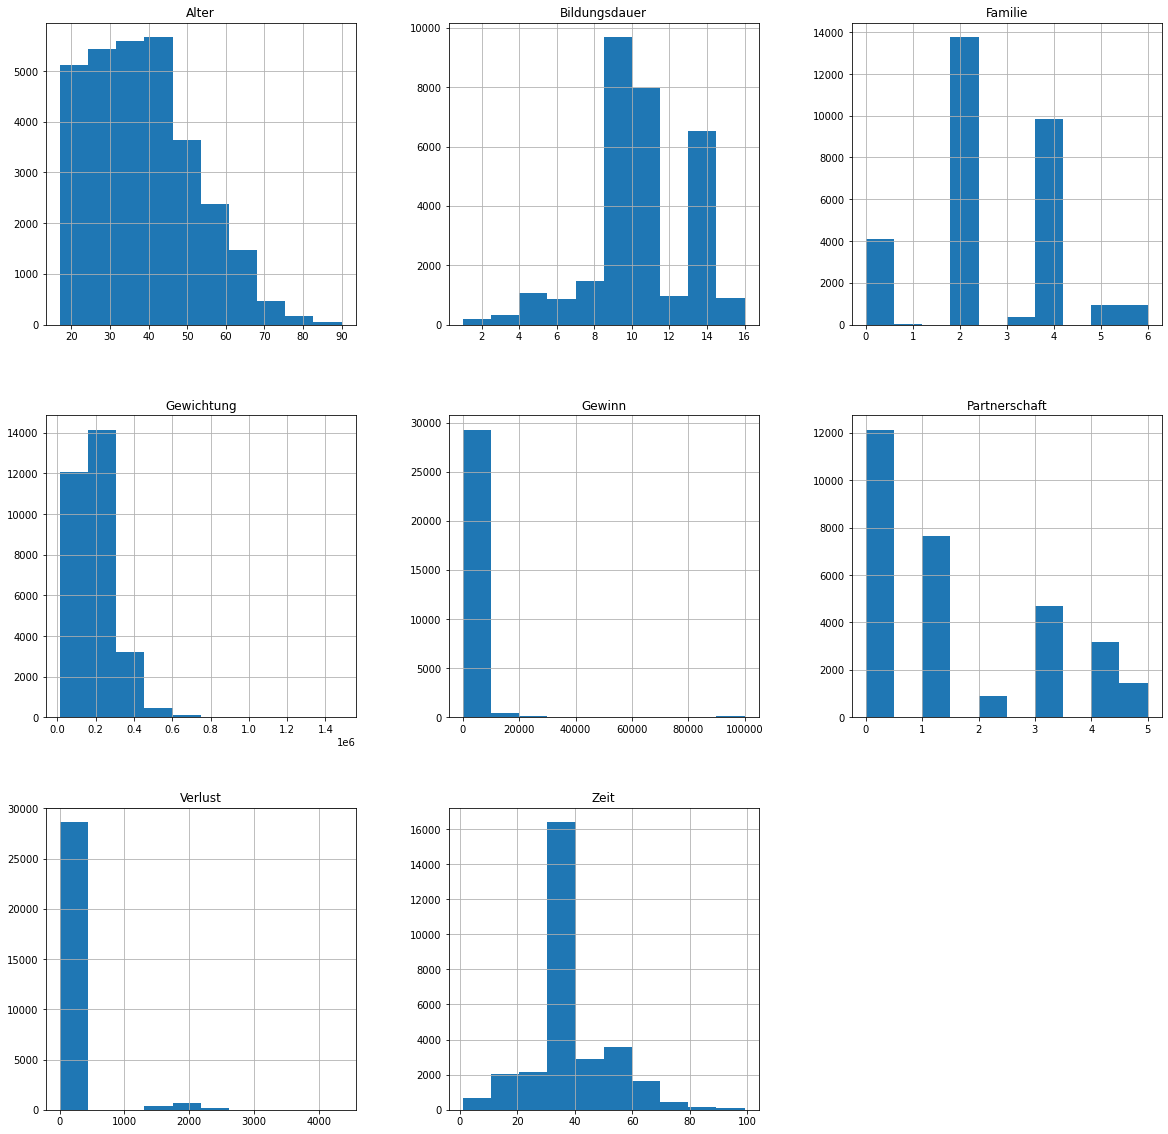

In [5]:
# visualize data
data = copy.deepcopy(df_work)
label_encoder = LabelEncoder()
data.Familie= label_encoder.fit_transform(data.Familie) 
data.Partnerschaft= label_encoder.fit_transform(data.Partnerschaft) 
data.hist(grid=True, figsize=(20, 20), column=['Alter', 'Gewichtung', 'Partnerschaft', 'Familie', 'Gewinn', 'Bildungsdauer', 'Verlust', 'Zeit'])

#to understand Labels in Plots
print('Familie:\n', pd.Series(df.Familie).value_counts())
print('Partnerschaft:\n', df.Partnerschaft.value_counts())

In [6]:
# extract train and test data
workdata = df_work[df_work.Einkommen != ' ?']
# extract data to apply model
applydata = df_work[df_work.Einkommen == ' ?']
#print(df.info())
#preprocessing
# Überblick über unbekannte Daten der verbleibenden Attribute
wdNames = workdata.columns.values
for i in wdNames:
    print(i)
    print(workdata[str(i)].loc[workdata[str(i)] == ' ?'].value_counts())

# one hot encoding aller daten bis auf Einkommen, deutlich mehr Attribute

wd = pd.get_dummies(workdata.iloc[:,:df_work.shape[1]-1])
wd['Einkommen'] = workdata['Einkommen']
wd.shape


Alter
Series([], Name: Alter, dtype: int64)
Familie
Series([], Name: Familie, dtype: int64)
Gewichtung
Series([], Name: Gewichtung, dtype: int64)
Gewinn
Series([], Name: Gewinn, dtype: int64)
Bildungsdauer
Series([], Name: Bildungsdauer, dtype: int64)
Verlust
Series([], Name: Verlust, dtype: int64)
Zeit
Series([], Name: Zeit, dtype: int64)
Partnerschaft
Series([], Name: Partnerschaft, dtype: int64)
Einkommen
Series([], Name: Einkommen, dtype: int64)


(5000, 20)

In [7]:
# preprocessing
# splitting in Y und X


X = wd.iloc[:,:wd.shape[1]-1] # alle Daten außer Einkommen
y = wd.iloc[:,wd.shape[1]-1:] #letztendliche Klassifizierung nach Einkommen

X.shape

(5000, 19)

In [8]:
# 5000 Data known => split in Test and Train; 25000 Data to apply model
# splitting in test and training data
y=y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)

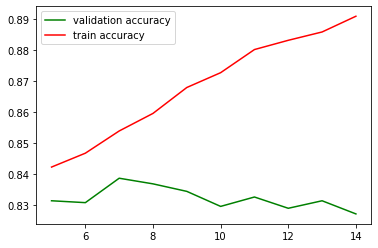

In [9]:
# Tuning max_depth
accs = []
accs_train = []
for max_depth in range(1,15):
    clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, min_samples_split=5)
    clf_tree.fit(X_train, y_train)
    accs.append(clf_tree.score(X_test, y_test))
    accs_train.append(clf_tree.score(X_train, y_train))
    
sns.lineplot(x= range(5,len(accs)+1), y=accs[4:], color= "green", label = "validation accuracy")
sns.lineplot(x= range(5,len(accs_train)+1), y=accs_train[4:], color= "red", label = "train accuracy");


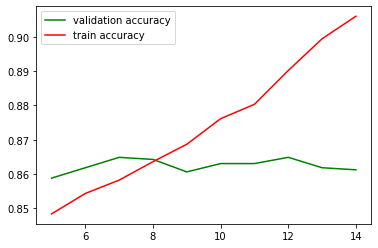

In [10]:
accs = []
accs_train = []
for max_depth in range(1,15):
    clf_tree = RandomForestClassifier(n_estimators = 200, criterion='entropy', max_depth=max_depth, min_samples_split=5)
    clf_tree.fit(X_train, y_train)
    accs.append(clf_tree.score(X_test, y_test))
    accs_train.append(clf_tree.score(X_train, y_train))
    
sns.lineplot(x= range(5,len(accs)+1), y=accs[4:], color= "green", label = "validation accuracy")
sns.lineplot(x= range(5,len(accs_train)+1), y=accs_train[4:], color= "red", label = "train accuracy");
# nach mehreren Plots: Tiefe von 8-10

In [11]:
# baseline (prediction of majority class)
# evaluation
# code to one of the lecturers (Paul Prasse or Silvia Makrovski (or something))
# know everything

# erstellen des Decision Trees mit dem Splitkriterium Entropy, und Best-split, maximale Tiefe ist 5
# Ändern von min_samples_leaf = default = 1 zu 25 nach Baum plot
clf_t = DecisionTreeClassifier(criterion = 'entropy', splitter = 'best', max_depth=5, min_samples_split = 5, min_samples_leaf = 25)
clf_tree = clf_t.fit(X_train, y_train)
y_pred_tree = clf_tree.predict(X_test)

# forest
clf_f=RandomForestClassifier(n_estimators=200, criterion = 'entropy', max_depth=9, min_samples_split = 5)
clf_forest = clf_f.fit(X_train,y_train)
y_pred_forest=clf_forest.predict(X_test)
#print(roc_curve(y_test, y_pred))

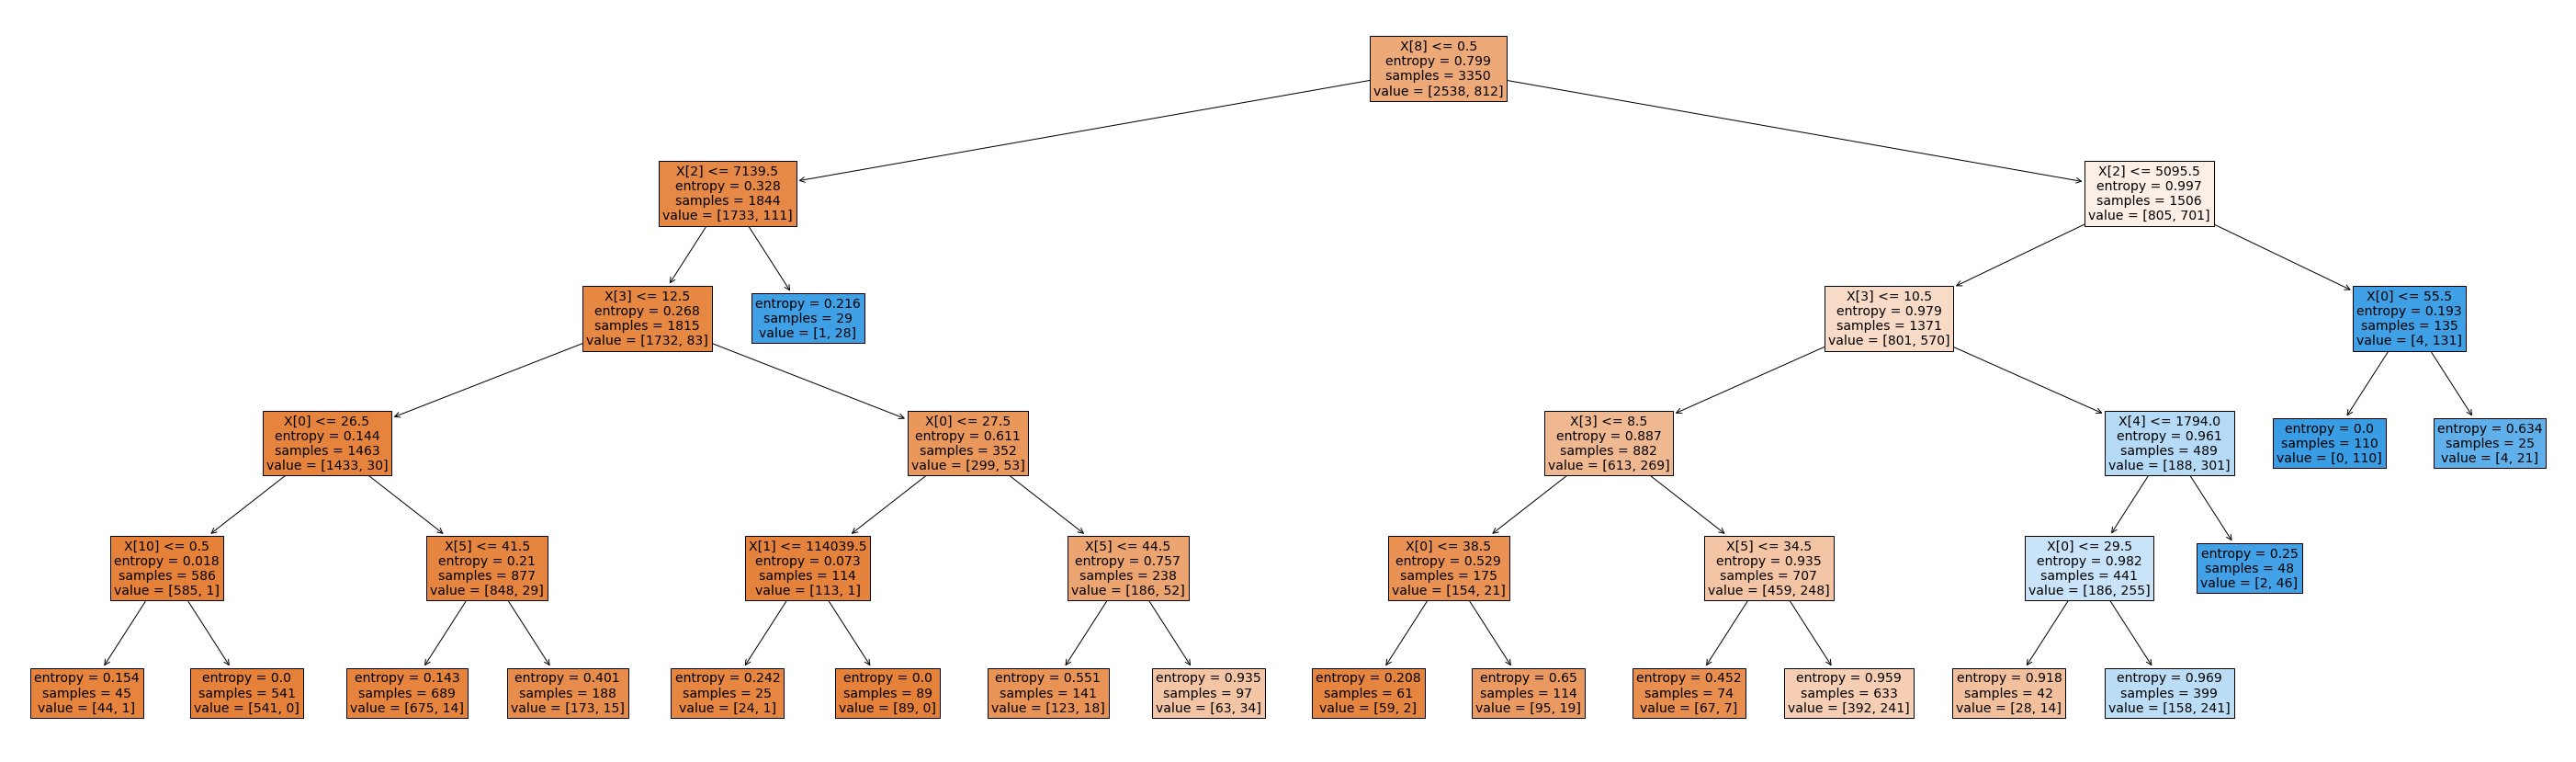

In [12]:
from sklearn.tree import plot_tree
plt.figure(figsize=(50,15))

plot_tree(clf_t, filled = True, fontsize=14);

In [13]:
from sklearn.model_selection import cross_val_score

print('Metrics on Testdata')
print('Accuracy(Tree):', accuracy_score(y_test, y_pred_tree))
print('Accuracy(Forest):', accuracy_score(y_test, y_pred_forest))
print('Recall (Tree):', recall_score(y_test, y_pred_tree))
print('Recall (Forest):', recall_score(y_test, y_pred_forest))
print('Precision (Tree):', precision_score(y_test, y_pred_tree))
print('Precision (Forest):', precision_score(y_test, y_pred_forest))
print('F1 Score (Tree):',f1_score(y_test, y_pred_tree))
print('F1 Score (Forest):',f1_score(y_test, y_pred_forest))

print()
print('Metrics on all data')
print('Accuracy (Tree):', accuracy_score(y, clf_tree.predict(X)))
print('Accuracy (Forest):', accuracy_score(y, clf_forest.predict(X)))
print('Recall (Tree):', recall_score(y, clf_tree.predict(X)))
print('Recall (Forest):', recall_score(y, clf_forest.predict(X)))
print('Precision (Tree):', precision_score(y, clf_tree.predict(X)))
print('Precision (Forest):', precision_score(y, clf_forest.predict(X)))
print('F1 Score (Tree):',f1_score(y, clf_tree.predict(X)))
print('F1 Score (Forest):',f1_score(y, clf_forest.predict(X)))

# 5-fold cross validation
print('Crossvalidation (Tree):\n', cross_val_score(clf_tree, X_test, y_test))
print('Crossvalidation (Forest):\n',cross_val_score(clf_forest, X_test, y_test))

# min_samples_leaf = 1 => accuracy = 0.82

Metrics on Testdata
Accuracy(Tree): 0.8387878787878787
Accuracy(Forest): 0.8612121212121212
Recall (Tree): 0.5550122249388753
Recall (Forest): 0.5745721271393643
Precision (Tree): 0.729903536977492
Precision (Forest): 0.8103448275862069
F1 Score (Tree): 0.6305555555555556
F1 Score (Forest): 0.6723891273247498

Metrics on all data
Accuracy (Tree): 0.8406
Accuracy (Forest): 0.8662
Recall (Tree): 0.5511875511875511
Recall (Forest): 0.5847665847665847
Precision (Tree): 0.7299349240780911
Precision (Forest): 0.815068493150685
F1 Score (Tree): 0.6280914605692953
F1 Score (Forest): 0.6809728183118741
Crossvalidation (Tree):
 [0.84545455 0.83030303 0.84242424 0.84242424 0.81212121]
Crossvalidation (Forest):
 [0.86060606 0.85151515 0.85454545 0.86666667 0.85454545]


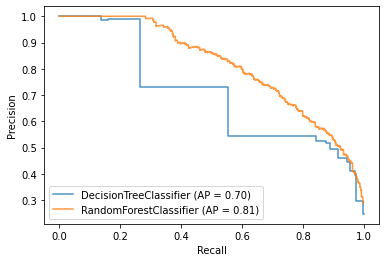

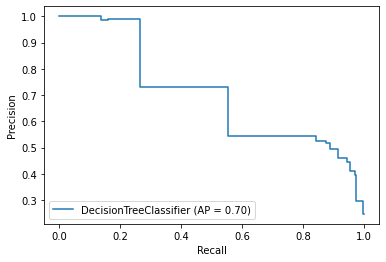

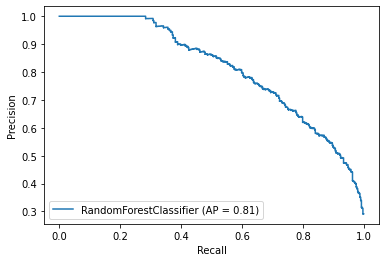

In [14]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

ax = plt.gca()

average_precision_tree = average_precision_score(y_test, y_pred_tree)
r_p_tree = plot_precision_recall_curve(clf_tree, X_test, y_test)
r_p_tree.plot(ax=ax, alpha=0.8)
average_precision_forest = average_precision_score(y_test, y_pred_forest)
r_p_forest = plot_precision_recall_curve(clf_forest, X_test, y_test)
r_p_forest.plot(ax = ax, alpha=0.8)

Precision-Recall curve on all data:


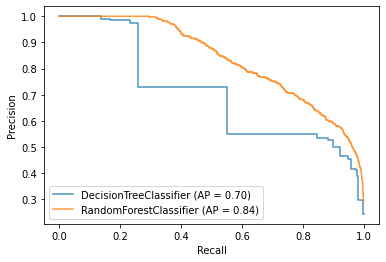

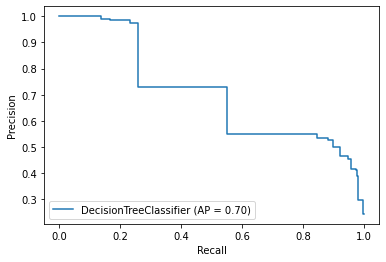

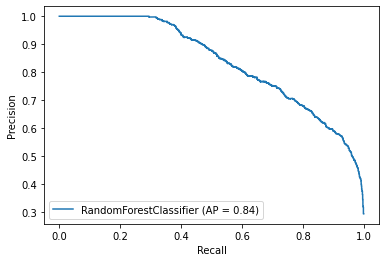

In [15]:
ax = plt.gca()
print('Precision-Recall curve on all data:')
average_precision_tree_all = average_precision_score(y, clf_tree.predict(X))
r_p_tree_all= plot_precision_recall_curve(clf_tree, X, y)
r_p_tree_all.plot(ax = ax, alpha=0.8)

average_precision_forest_all = average_precision_score(y, clf_forest.predict(X))
r_p_forest_all = plot_precision_recall_curve(clf_forest, X, y)
r_p_forest_all.plot(ax = ax, alpha=0.8)

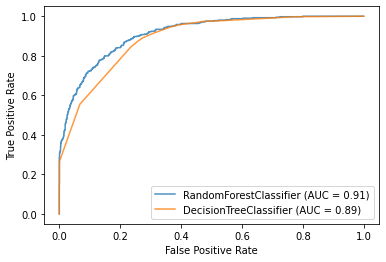

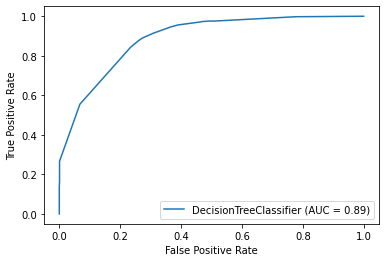

In [16]:
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ax = plt.gca()
clf_forest_disp = plot_roc_curve(clf_forest, X_test, y_test, ax=ax, alpha=0.8)
clf_tree_disp = plot_roc_curve(clf_tree, X_test, y_test)
clf_tree_disp.plot(ax=ax, alpha=0.8)
plt.show()

In [17]:
# Anwendung auf andere Data
# What I did:
# generated one hot encoding for data to apply model to
# noticed, that there are 3 attributes, which do not appear in trainingsdata

# Deal with these data (18 Samples):
# replacing with ' ?' (not cool)
# deleting is no option
# replacing with local near places, which are an attribute of traindata?

#applyName = apply.columns.values
#wdName = wd.columns.values
#cmp = []
#for i in applyName:
#    if i not in wdName:
#        cmp.append(i)
#print(cmp)
#apply.loc[:,'Beschaeftigung_ Never-worked' == 0]
#print('Never-worked:\n',apply['Beschaeftigung_ Never-worked'].value_counts())
#print("Data Beschäftigung = Never worked:\n",applydata.loc[applydata['Beschaeftigung'] == ' Never-worked'].Einkommen.value_counts()) # 5
#print("Data Geburtsland = Holand-Netherlands:\n",applydata.loc[applydata['Geburtsland'] == ' Holand-Netherlands'].Einkommen.value_counts()) # 1
#print("Data Geburtsland = Hungary:\n",applydata.loc[applydata['Geburtsland'] == ' Hungary'].Einkommen.value_counts()) # 12

apply = pd.get_dummies(applydata.iloc[:,:applydata.shape[1]-1])

print(apply.shape)
y_out_tree = clf_tree.predict(apply)
y_out_forest = clf_forest.predict(apply)

(25000, 19)


In [18]:
data_tree_applied, data_forest_applied = applydata, applydata
# reformating & merging to have an overview about all data and attributes
data_tree_applied['Einkommen'] = y_out_tree
data_tree_applied['Einkommen'].replace({1: ' >50K', 0 : ' <=50K'}, inplace = True)
applydata_tree = copy.deepcopy(df.loc[df['Einkommen'] == ' ?'])
applydata_tree['Einkommen'] = data_tree_applied['Einkommen']
print(applydata_tree)
data_forest_applied['Einkommen'] = y_out_forest
data_forest_applied['Einkommen'].replace({1: ' >50K', 0 : ' <=50K'}, inplace = True)
applydata_forest = copy.deepcopy(df.loc[df['Einkommen'] == ' ?'])
applydata_forest['Einkommen'] = data_forest_applied['Einkommen']
applydata_forest

       Alter Beschaeftigung  Gewichtung   Bildungsgrad  Bildungsdauer  \
5000      47   Self-emp-inc       79627    Prof-school             15   
5001      55        Private      151474      Bachelors             13   
5002      26        Private      132661        HS-grad              9   
5003      28        Private      161674        HS-grad              9   
5004      36        Private       62346        HS-grad              9   
...      ...            ...         ...            ...            ...   
29995     30        Private       55481        Masters             14   
29996     48        Private      119471      Assoc-voc             11   
29997     61      Local-gov      167347   Some-college             10   
29998     41        Private      184378        HS-grad              9   
29999     36        Private      348960        HS-grad              9   

                   Familie             Bereich    Partnerschaft  \
5000              Divorced      Prof-specialty    Not-in

,Alter,Beschaeftigung,Gewichtung,Bildungsgrad,Bildungsdauer,Familie,Bereich,Partnerschaft,Ethnie,Geschlecht,Gewinn,Verlust,Zeit,Geburtsland,Einkommen
5000,47,Self-emp-inc,79627,Prof-school,15,Divorced,Prof-specialty,Not-in-family,White,Male,27828,0,50,United-States,>50K
5001,55,Private,151474,Bachelors,13,Never-married,Tech-support,Other-relative,White,Female,0,1590,38,United-States,<=50K
5002,26,Private,132661,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,5013,0,40,United-States,<=50K
5003,28,Private,161674,HS-grad,9,Never-married,Machine-op-inspct,Unmarried,White,Female,0,0,40,United-States,<=50K
5004,36,Private,62346,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,Black,Male,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,30,Private,55481,Masters,14,Never-married,Tech-support,Unmarried,White,Male,0,0,45,Nicaragua,<=50K
29996,48,Private,119471,Assoc-voc,11,Married-civ-spouse,Other-service,Husband,Asian-Pac-Islander,Male,0,0,56,Philippines,>50K
29997,61,Local-gov,167347,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,35,United-States,<=50K
29998,41,Private,184378,HS-grad,9,Separated,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [19]:
feature_imp_t = pd.Series(clf_tree.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp_f = pd.Series(clf_forest.feature_importances_,index=X.columns).sort_values(ascending=False)

No handles with labels found to put in legend.


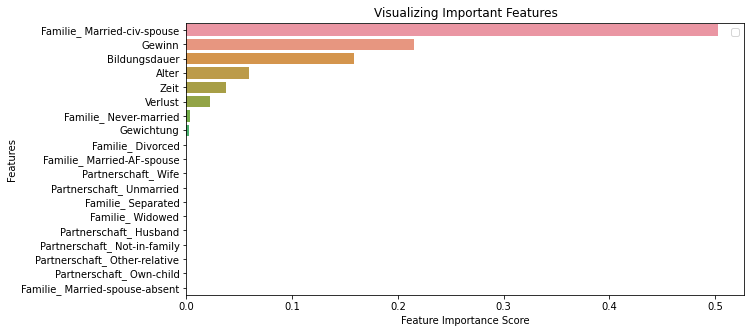

In [20]:
import seaborn as sns
%matplotlib inline
# Creating a bar plot

sns.barplot(x=feature_imp_t, y=feature_imp_t.index)
fig = plt.gcf()
fig.set_size_inches(10, 5)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

No handles with labels found to put in legend.


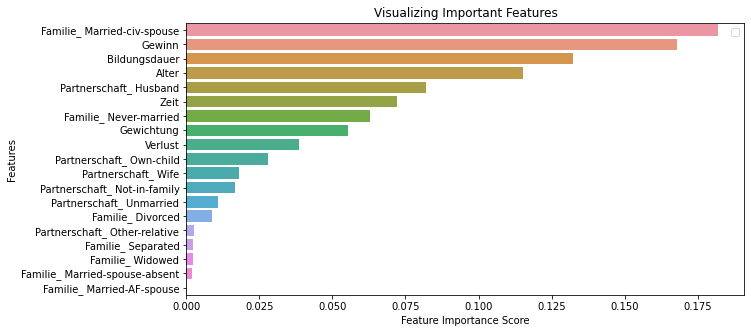

In [21]:
import seaborn as sns
%matplotlib inline
# Creating a bar plot

sns.barplot(x=feature_imp_f, y=feature_imp_f.index)
fig = plt.gcf()
fig.set_size_inches(10, 5)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

##### 